In [1]:
import pickle
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2
import time
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.layers as l
import tensorflow.keras.backend as K

import tensorflow.keras.optimizers as o
import tensorflow.keras.models as m
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

import random
import os

# Load the data sets
- MNIST
- eMNIST
- my custom one

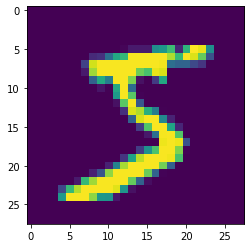

In [4]:
# mnist
mnist = keras.datasets.mnist 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

mnist_x_train = np.asarray(mnist_x_train)
mnist_x_test = np.asarray(mnist_x_test)

mnist_y_train = mnist_y_train.reshape((mnist_y_train.shape[0], 1))
mnist_y_test = mnist_y_test.reshape((mnist_y_test.shape[0], 1))


plt.imshow(mnist_x_train[0])
plt.show()


---

In [3]:
# emnist
from scipy.io import loadmat

EMNIST_digits_file = os.path.join("..", "number_dataset","emnist-digits.mat")
mat = loadmat(EMNIST_digits_file)
data = mat['dataset']

emnist_x_train = data['train'][0,0]['images'][0,0]
emnist_x_test = data['test'][0,0]['images'][0,0]
emnist_x_train = emnist_x_train.reshape( (emnist_x_train.shape[0], 28, 28), order='F')
emnist_x_test = emnist_x_test.reshape( (emnist_x_test.shape[0], 28, 28), order='F')

emnist_y_train = data['train'][0,0]['labels'][0,0]
emnist_y_test = data['test'][0,0]['labels'][0,0]

---

In [5]:
# custom one
custom_dataset_path = os.path.join("..", "number_dataset", "COMPLETE_DATASET_clean")
custom_dataset_names = os.listdir(custom_dataset_path)

IMG_SIZE = 28
custom_dataset = []
custom_labels = []

for i,img_name in enumerate(custom_dataset_names):
    # load image gray scale
    img = cv2.imread(os.path.join(custom_dataset_path,img_name), cv2.IMREAD_GRAYSCALE)
    # resize to 28x28
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE), 1)
    #thress hold it 
    ret, t_img = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)# THRESH_TOZERO_INV or THRESH_BINARY_INV
    ret, img = cv2.threshold(img, 200, 255, cv2.THRESH_TOZERO_INV)

    # append it
    custom_dataset.append(img)

    # label
    current_label = np.zeros(10)
    current_label[int(img_name[0])]=1
    custom_labels.append(current_label)
    
#     plt.imshow(img)
#     plt.show()


my_seed = int(10*random.random())
random.Random(my_seed).shuffle(custom_dataset)
random.Random(my_seed).shuffle(custom_labels)

custom_x_train = np.asarray(custom_dataset[:int(0.75*len(custom_dataset))])
custom_y_train = np.asarray(custom_labels[:int(0.75*len(custom_labels))])

custom_x_test = np.asarray(custom_dataset[int(0.75*len(custom_dataset)):])
custom_y_test = np.asarray(custom_labels[int(0.75*len(custom_labels)):])

In [5]:
print(emnist_y_train.shape)
print(mnist_y_train.shape)
print(custom_y_train.shape)

(240000, 1)
(60000, 1)
(1266, 10)


---

## Concatenate them all

In [6]:
# concat them all

x_train, x_test = np.concatenate((emnist_x_train, mnist_x_train)), np.concatenate((emnist_x_test, mnist_x_test))
x_train, x_test = np.concatenate((x_train, custom_x_train)), np.concatenate((x_test, custom_x_test))

# after augmentation
# x_train, x_test = ((1.0/255.0)*x_train).reshape([-1, 28, 28, 1]), ((1.0/255.0)*x_test).reshape([-1, 28, 28, 1]) 

y_train, y_test = np.concatenate((emnist_y_train, mnist_y_train)), np.concatenate((emnist_y_test, mnist_y_test))
y_train, y_test = keras.utils.to_categorical(y_train, 10), keras.utils.to_categorical(y_test, 10)
y_train, y_test = np.concatenate((y_train, custom_y_train)), np.concatenate((y_test, custom_y_test))

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(301266, 28, 28)
(301266, 10)
(50422, 28, 28)
(50422, 10)


---

## Create some augmentated dataset

In [8]:
def mirro_rotate(dataset, dataset_labels, ROT_DEGGREES=20):
    augmented_image = []
    augmented_image_labels = []
    
    for num in range (0, dataset.shape[0]):
        # original image:
        augmented_image.append(dataset[num])
        augmented_image_labels.append(dataset_labels[num])
        #rotate 
        height, width = dataset[num].shape
        
        rotation_matrix = cv2.getRotationMatrix2D((width/2,height/2), ROT_DEGGREES ,1)
        rotated_image = cv2.warpAffine(dataset[num], rotation_matrix, (width, height))
        augmented_image.append(rotated_image)
        augmented_image_labels.append(dataset_labels[num])
        
        rotation_matrix = cv2.getRotationMatrix2D((width/2,height/2), (-1)*ROT_DEGGREES ,1)
        rotated_image = cv2.warpAffine(dataset[num], rotation_matrix, (width, height))
        augmented_image.append(rotated_image)
        augmented_image_labels.append(dataset_labels[num])
    
    return np.array(augmented_image), np.array(augmented_image_labels)

In [9]:
x_train, y_train = mirro_rotate(x_train, y_train, 10)
print(x_train.shape)
print(y_train.shape)

(903798, 28, 28)
(903798, 10)


## Prepare the data

In [10]:
x_train, x_test = ((1.0/255.0)*x_train).reshape([-1, 28, 28, 1]), ((1.0/255.0)*x_test).reshape([-1, 28, 28, 1]) 

## Make the Network

In [11]:
model = m.Sequential()

model.add(l.Conv2D(49, (3,3), padding='same', activation='relu', input_shape = (28,28,1)))
model.add(l.MaxPooling2D((3,3)))
model.add(l.Conv2D(36, (3,3), padding='same', activation='relu'))
model.add(l.MaxPooling2D((3,3)))

model.add(l.Flatten())
model.add(l.Dense(32, activation="relu"))
model.add(l.Dropout(rate=0.5))
model.add(l.Dense(64, activation="relu"))

model.add(l.Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 49)        490       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 49)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 36)          15912     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 324)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

### CallBacks: TensorBoard + EarlyStop

In [12]:
name = "tf_{}.log".format(int(time.time()))
print("lon_name: ",name)
tensorboard = TensorBoard(log_dir='logs/{}'.format(name))

earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1, patience=0,
    verbose=0, mode='auto',
    baseline=None,
    restore_best_weights=False
)

lon_name:  tf_1579361220.log


In [13]:
model.fit(x_train, y_train, epochs=5, callbacks=[tensorboard, earlystop], validation_data = (x_test,y_test))

Train on 903798 samples, validate on 50422 samples
Epoch 1/5


 26656/903798 [..............................] - ETA: 8:42:49 - loss: 2.3105 - accuracy: 0.093 - ETA: 3:03:31 - loss: 2.2962 - accuracy: 0.093 - ETA: 1:22:04 - loss: 2.2863 - accuracy: 0.107 - ETA: 50:07 - loss: 2.2903 - accuracy: 0.1042  - ETA: 36:58 - loss: 2.2928 - accuracy: 0.110 - ETA: 29:46 - loss: 2.2918 - accuracy: 0.099 - ETA: 25:12 - loss: 2.2884 - accuracy: 0.105 - ETA: 22:05 - loss: 2.2848 - accuracy: 0.114 - ETA: 19:45 - loss: 2.2771 - accuracy: 0.123 - ETA: 18:01 - loss: 2.2693 - accuracy: 0.130 - ETA: 16:41 - loss: 2.2600 - accuracy: 0.139 - ETA: 15:35 - loss: 2.2449 - accuracy: 0.149 - ETA: 14:42 - loss: 2.2300 - accuracy: 0.160 - ETA: 13:57 - loss: 2.2137 - accuracy: 0.167 - ETA: 13:19 - loss: 2.1932 - accuracy: 0.177 - ETA: 12:45 - loss: 2.1682 - accuracy: 0.187 - ETA: 12:15 - loss: 2.1480 - accuracy: 0.198 - ETA: 11:49 - loss: 2.1259 - accuracy: 0.205 - ETA: 11:26 - loss: 2.1028 - accuracy: 0.215 - ETA: 11:12 - loss: 2.0841 - accuracy: 0.224 - ETA: 10:52 - loss: 2.05

 82848/903798 [=>............................] - ETA: 5:39 - loss: 0.7138 - accuracy: 0.74 - ETA: 5:39 - loss: 0.7133 - accuracy: 0.74 - ETA: 5:39 - loss: 0.7127 - accuracy: 0.74 - ETA: 5:38 - loss: 0.7120 - accuracy: 0.74 - ETA: 5:38 - loss: 0.7112 - accuracy: 0.74 - ETA: 5:38 - loss: 0.7104 - accuracy: 0.74 - ETA: 5:38 - loss: 0.7095 - accuracy: 0.74 - ETA: 5:38 - loss: 0.7085 - accuracy: 0.74 - ETA: 5:37 - loss: 0.7078 - accuracy: 0.74 - ETA: 5:37 - loss: 0.7076 - accuracy: 0.74 - ETA: 5:37 - loss: 0.7069 - accuracy: 0.75 - ETA: 5:37 - loss: 0.7058 - accuracy: 0.75 - ETA: 5:37 - loss: 0.7053 - accuracy: 0.75 - ETA: 5:36 - loss: 0.7046 - accuracy: 0.75 - ETA: 5:36 - loss: 0.7041 - accuracy: 0.75 - ETA: 5:36 - loss: 0.7029 - accuracy: 0.75 - ETA: 5:36 - loss: 0.7022 - accuracy: 0.75 - ETA: 5:36 - loss: 0.7013 - accuracy: 0.75 - ETA: 5:36 - loss: 0.7006 - accuracy: 0.75 - ETA: 5:35 - loss: 0.6998 - accuracy: 0.75 - ETA: 5:35 - loss: 0.6990 - accuracy: 0.75 - ETA: 5:35 - loss: 0.6982 - 

 93120/903798 [==>...........................] - ETA: 5:18 - loss: 0.6078 - accuracy: 0.78 - ETA: 5:18 - loss: 0.6074 - accuracy: 0.78 - ETA: 5:18 - loss: 0.6070 - accuracy: 0.78 - ETA: 5:17 - loss: 0.6065 - accuracy: 0.78 - ETA: 5:17 - loss: 0.6060 - accuracy: 0.78 - ETA: 5:17 - loss: 0.6057 - accuracy: 0.78 - ETA: 5:17 - loss: 0.6053 - accuracy: 0.78 - ETA: 5:17 - loss: 0.6049 - accuracy: 0.78 - ETA: 5:17 - loss: 0.6045 - accuracy: 0.78 - ETA: 5:17 - loss: 0.6041 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6037 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6034 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6029 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6025 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6021 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6017 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6014 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6010 - accuracy: 0.78 - ETA: 5:16 - loss: 0.6008 - accuracy: 0.78 - ETA: 5:15 - loss: 0.6003 - accuracy: 0.78 - ETA: 5:15 - loss: 0.5999 - accuracy: 0.78 - ETA: 5:15 - loss: 0.5995 - 

KeyboardInterrupt: 

---

---